In [1]:
import torch
from utils import DataManager, dataset_sizes, collect_training_data, compute_statistics, compute_average_accuracies
import matplotlib.pyplot as plt
from probes import CCSProbe, LRProbe, MMProbe, ALL_PROBES, TTPD_TYPES, measure_polarity_direction_lr, run_ray, get_average_feature_importance, TTPDTestConfigurable
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import pandas as pd

In [2]:
# Parameters
figure_output_dir = ""
model_family = 'Llama3' # options are 'Llama3', 'Llama2', 'Gemma', 'Gemma2' or 'Mistral'
model_size = '8B'
model_type = 'chat' # options are 'chat' or 'base'
layer = 12 # layer from which to extract activations

In [3]:
device = 'mps' if torch.mps.is_available() else 'cpu' # mps speeds up CCS training a fair bit but is not required
device = "cuda" if torch.cuda.is_available() else device # cuda speeds it up a bit more
device

'cuda'

In [4]:
train_sets = ['colleague', 'friends', 'lawyer', 'police', "real_estate_agent", "soccer", "teacher"]
train_sets = ["b_w_lies/" + val for val in train_sets]
# get size of each training dataset to include an equal number of statements from each topic in training data
train_set_sizes = dataset_sizes(train_sets) 
print(train_set_sizes)

{'b_w_lies/colleague': 150, 'b_w_lies/friends': 122, 'b_w_lies/lawyer': 148, 'b_w_lies/police': 127, 'b_w_lies/real_estate_agent': 218, 'b_w_lies/soccer': 132, 'b_w_lies/teacher': 127}


## Distribution of the dataset

In [5]:
import pandas as pd

def compute_label_distribution(train_sets):
    """
    Given a list of dataset paths (CSV files) with a binary label in the second column,
    prints and returns the percentage of BLACK and WHITE labels for each dataset.
    """
    results = {}
    for dataset_path in train_sets:
        try:
            df = pd.read_csv(f"datasets/{dataset_path}.csv", header=None)
            labels = df.iloc[:, 1]  # Second column

            total = len(labels)
            if total == 0:
                print(f"{dataset_path}: EMPTY dataset")
                results[dataset_path] = {"BLACK": 0, "WHITE": 0}
                continue

            black_count = (labels == "BLACK").sum()
            white_count = (labels == "WHITE").sum()

            black_pct = 100 * black_count / total
            white_pct = 100 * white_count / total

            results[dataset_path] = {"BLACK": black_pct, "WHITE": white_pct}
            print(f"{dataset_path}: {black_pct:.1f}% BLACK, {white_pct:.1f}% WHITE")

        except FileNotFoundError:
            print(f"File not found: {dataset_path}.csv")
        except Exception as e:
            print(f"Error processing {dataset_path}: {e}")

    return results


# Example usage:
train_sets = ['colleague', 'friends', 'lawyer', 'police', 'real_estate_agent', 'soccer', 'teacher']
train_sets = ["b_w_lies/" + val for val in train_sets]
distributions = compute_label_distribution(train_sets)


b_w_lies/colleague: 49.7% BLACK, 49.7% WHITE
b_w_lies/friends: 49.6% BLACK, 49.6% WHITE
b_w_lies/lawyer: 50.3% BLACK, 49.0% WHITE
b_w_lies/police: 49.2% BLACK, 50.0% WHITE
b_w_lies/real_estate_agent: 50.7% BLACK, 48.9% WHITE
b_w_lies/soccer: 49.6% BLACK, 49.6% WHITE
b_w_lies/teacher: 48.4% BLACK, 50.8% WHITE


In [6]:
probe_types = [t for (name, t) in [('LRProbe', LRProbe)]]
results = {t: defaultdict(list) for t in probe_types}
num_iter = 3

total_iterations = len(probe_types) * num_iter * len(train_sets)
with tqdm(total=total_iterations, desc="Training and evaluating classifiers") as pbar:
    for ProbeCls in probe_types:
        for _ in range(num_iter):
            for held_out in train_sets:
                # Train on all datasets except the held-out one
                cv_train_sets = [ds for ds in train_sets if ds != held_out]

                # Load training data (use whatever centering your Probe expects)
                acts_centered, acts, labels, polarities = collect_training_data(
                    cv_train_sets, train_set_sizes, model_family, model_size, model_type, layer
                )

                # Train probe (using uncentered acts here, adjust if your LRProbe expects centered)
                probe = ProbeCls.from_data(acts, labels)

                # Evaluate on the held-out dataset
                dm = DataManager()
                dm.add_dataset(held_out, model_family, model_size, model_type, layer,
                               split=None, center=False, device='cpu')
                acts_te, labels_te = dm.get(held_out) if hasattr(dm, "get") else dm.data[held_out]

                preds = probe.pred(acts_te)
                acc = (preds == labels_te).float().mean().item()
                results[ProbeCls][held_out].append(acc)

                pbar.update(1)

# Aggregate stats
stat_results = compute_statistics(results)
probe_accuracies = compute_average_accuracies(results, num_iter)



for name, stats in probe_accuracies.items():
    print(f"{name}:")
    print(f"  Mean Accuracy: {stats['mean']*100:.2f}%")
    print(f"  Standard Deviation of the mean accuracy: {stats['std_dev']*100:.2f}%")

Training and evaluating classifiers: 100%|██████████| 21/21 [00:10<00:00,  1.93it/s]

LRProbe:
  Mean Accuracy: 99.06%
  Standard Deviation of the mean accuracy: 0.16%


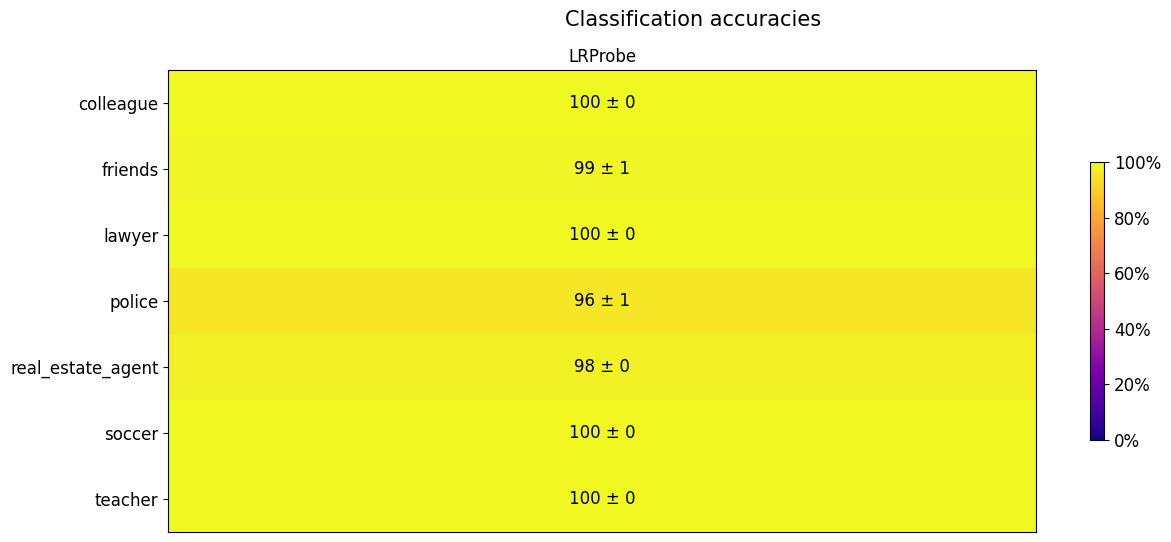

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os

# 1) Pick probes & titles (prefer ALL_PROBES if present)
try:
    probes = [LRProbe]  # only those we actually computed
    titles = ["LRProbe"]
except NameError:
    probes = list(stat_results.keys())
    titles = [getattr(p, "__name__", str(p)) for p in probes]

# 2) Build figure
fig, axes = plt.subplots(figsize=(14, 6), ncols=len(probes))
if len(probes) == 1:
    axes = [axes]

last_im = None
for idx, (ax, key) in enumerate(zip(axes, probes)):
    # Grid is (num_datasets x 1) so each row is a dataset
    grid = np.array([[stat_results[key]['mean'].get(ds, np.nan)] for ds in train_sets], dtype=float)
    grid_std = np.array([[stat_results[key]['std'].get(ds, np.nan)] for ds in train_sets], dtype=float)

    im = ax.imshow(grid, vmin=0, vmax=1, cmap='plasma', aspect='auto')
    last_im = im

    # Annotations as percent ± percent
    for i in range(grid.shape[0]):
        val = grid[i, 0]
        sd = grid_std[i, 0]
        if np.isfinite(val):
            ax.text(0, i, f"{val*100:.0f} ± {sd*100:.0f}",
                    ha='center', va='center', fontsize=12, color='white' if val < 0.5 else 'black')

    ax.set_yticks(range(len(train_sets)))
    ax.set_xticks([])
    ax.set_title(titles[idx], fontsize=12)

# 3) Y tick labels only on first subplot; strip prefix for readability
pretty_names = [ds.split('/')[-1] for ds in train_sets]
axes[0].set_yticklabels(pretty_names, fontsize=12)
for ax in axes[1:]:
    ax.set_yticklabels([])

# 4) Colorbar as percent
cbar = fig.colorbar(last_im, ax=axes, shrink=0.6, location="right")
cbar.ax.tick_params(labelsize=12)
cbar.formatter = mticker.PercentFormatter(xmax=1.0, decimals=0)
cbar.update_ticks()

fig.suptitle("Classification accuracies", fontsize=15)

if figure_output_dir:
    plt.savefig(os.path.join(figure_output_dir, "lr_accuracies.png"), dpi=300, bbox_inches="tight")

plt.show()
